# Тестовое задание на должность data scientist

Это тестовое задание доступно по публичной ссылке, [ссылка на задание](https://disk.yandex.ru/d/pnJkHYsLcYF9gQ).
В данном блокноте находится полная предобработка в соответствии с техническим заданием и подробным описанием всех шагов.

Здесь вы найдете:
- работу с географическими координатами(кодирование координат в адрес, поиск коррдинат в которых имеется наибольшее число объектов)
- заполнение пропусков и анализ содержания
- работу по поиску явных и неявных дубликатов в сырых данных, которые имеют разный формат написания.
- загрузка данных с api яндекс диска, кординаты кодируются через бесплатный опенсорсный Nominatim.

# Загрузка данных и библиотек

В этом разделе содержатся импорты необходимых для работы библиотек.
В рамках данного проекта мне потребуются только стандартные библиотеки, а еще библиотеки для работы с геоданными, такие как shapely и geopandas, Nominatim.

In [1]:
import requests
import pandas as pd
print('Версия pandas', pd.__version__)
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from collections import defaultdict
import tqdm.notebook as tqdm
from geopy.geocoders import Nominatim
import warnings
warnings.filterwarnings("ignore")
# Установка максимальной ширины вывода для ячеек
pd.set_option('display.max_colwidth', None)

from scipy.spatial import KDTree

Версия pandas 2.0.3


In [2]:
# ссылка на файл
public_link = 'https://disk.yandex.ru/d/pnJkHYsLcYF9gQ'
# меняем ссылку на прямую
direct_link = f'https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key={public_link}'
# обрабатываем запрос
response = requests.get(direct_link)
# Проверяем статус ответа
if response.status_code == 200:
    # Извлекаем прямую ссылку из JSON-ответа
    download_link = response.json()['href']
    print(f'Прямая ссылка для скачивания файла: {download_link}')

# Скачивание файла
file_response = requests.get(download_link)

# Сохранение файла на диск в Colab
file_path = '/content/test_boltneva.xlsx'

with open(file_path, 'wb') as file:
    file.write(file_response.content)

Прямая ссылка для скачивания файла: https://downloader.disk.yandex.ru/disk/3f38fe1046b83ea9ae199ecd389f9d0fcafa69df279f8452694c78d663089bdb/6675d47e/zM-N1ClgLFn0kuerxqOz3mEqML0Pd3atMmF8_r0z84whGFq9AMipsvS6kNYZn6Q2xqp9mnW0t8iIfGpVOBHccw%3D%3D?uid=0&filename=hotels_parsing_result.xlsx&disposition=attachment&hash=skDq/Tldy2ynf3k3U8TQ9ViNPO%2Bs%2BAs5jeTC/uFcMVS9R%2BMrbEO4kmcigRSqBperq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fvnd.openxmlformats-officedocument.spreadsheetml.sheet&owner_uid=20835864&fsize=1010290&hid=9358b03409e4c0f743f7b3f2afc7d675&media_type=document&tknv=v2


Прежде чем начать работать с данными необходимо проверить какие страницы содержит наш документ excel.

In [3]:
# Вынесем путь к файлу в переменную
file_path = '/content/test_boltneva.xlsx'
# сохраним excel файл
xls = pd.ExcelFile(file_path)
# Посмотрим какие есть листы в документы
print(f'''Документ содержит следующие листы: {xls.sheet_names}''')

Документ содержит следующие листы: ['platform1', 'platfrom2']


Видим, что листы совпадают с ожидаемым количеством, но в одном из них содержится опечатка. Это не влияет на работу с документом, поэтому игнорируем это и не меняем.

In [4]:
# открываем данные в формате dataframe для первой платформы
platform1 = pd.read_excel(file_path, sheet_name = 'platform1')
platform1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5522 entries, 0 to 5521
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5522 non-null   int64  
 1   create_time          5522 non-null   object 
 2   title                5522 non-null   object 
 3   hotel_type_original  5522 non-null   object 
 4   city                 5522 non-null   object 
 5   address              5522 non-null   object 
 6   rating               5522 non-null   float64
 7   rating_5             5522 non-null   float64
 8   review_count         5522 non-null   int64  
 9   region               5522 non-null   int64  
 10  star_rating          311 non-null    float64
 11  rooms_count          856 non-null    float64
 12  contact_social       0 non-null      float64
 13  description          0 non-null      float64
 14  email                0 non-null      float64
 15  phone                0 non-null      f

Видим что имеются колонки в которых совсем отсутствует информация: contact_social, description,  email, phone, website.

И в двух колонках содержатся пропуски star_rating, rooms_count.

Имеются колонки содержащие время, их необходимо привести к формату datetime.

In [5]:
# открываем данные в формате dataframe для второй платформы
platform2 = pd.read_excel(file_path, sheet_name = 'platfrom2')
platform2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2767 entries, 0 to 2766
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   2767 non-null   int64  
 1   create_time          2767 non-null   object 
 2   title                2767 non-null   object 
 3   hotel_type_original  2747 non-null   object 
 4   city                 1622 non-null   object 
 5   address              2767 non-null   object 
 6   rating               2119 non-null   float64
 7   rating_5             2119 non-null   float64
 8   review_count         2119 non-null   float64
 9   region               2767 non-null   int64  
 10  star_rating          591 non-null    float64
 11  rooms_count          1662 non-null   float64
 12  contact_social       506 non-null    object 
 13  description          197 non-null    object 
 14  email                67 non-null     object 
 15  phone                1076 non-null   o

Данные со второй платформы содержат больше пропущенных значений, и не содержат колонок с отсутствующими данными.

Также имеютя колонки содержащие время, их необходимо привести к формату datetime.

In [6]:
# убедимся что документы содержат одинаковые колонки
platform1.columns.equals(platform2.columns)

True

Данные для обеих платформ загружены.
Видим, что:
- данные содержат пропуски
- данные содержатся в различных форматах, некоторые колонки с датой необходимо  привести к формату datetime. Колонки с телефонным номером нужно проверить почему тип данных категориальный, а не int. Вероятно из-за пропущенных
- Колонки в обеих таблицах идентичны по названиям и количеству.



# Предварительный анализ и предобработка

В рамках технического задания имеются конкретные требования по оформлению некоторых данных, например:  
- *email, сайтов распарсить и сохранить как списки в одинаковом формате ( address@domen.org, 79234553322, domen.ru)*
- *Формат записи названия, адреса, типа гостиницы отличается в разных
платформах*
- *Поля телефона, email, сайтов могу содержать лишние символы, несколько
записей и прочее*

Общую предобработку я буду осуществлять по следующему алгоритму:
1. Сначала приведу все данные к требуемому формату (колонки с датой к типу datetime)
2. Далее проанализирую названия заведений, тип заведений, населенных пунктов и, при возможности, приведу к единой форме записи.
3. После этого я проанализирую пропущенные данные и попробую их заполнить синтетическими данными либо заглушками, если не пойму их природу.
4. Проверю дубликаты
5. При наличии подходящего признака сджойню данные с обеих платформ
6. Выведу данные в требуемом формате

### create_time и parsing_time

In [7]:
# Посмотрим еще раз на признаки, содержащие дату
platform1[['create_time', 'parsing_time']]

,create_time,parsing_time
0,2023-09-26 14:45:42.910962,2023-09-26 20:56:02.013106
1,2023-09-26 15:01:55.184815,2023-09-26 20:56:02.013106
2,2023-09-26 15:02:12.005085,2023-09-26 20:56:02.013106
3,2023-09-26 15:02:12.225334,2023-09-26 20:56:02.013106
4,2023-09-26 15:00:19.217359,2023-09-26 20:56:02.013106
...,...,...
5517,2023-09-26 15:03:21.089955,2023-09-26 20:56:02.013106
5518,2023-09-26 15:03:30.721937,2023-09-26 20:56:02.013106
5519,2023-09-26 15:04:39.726907,2023-09-26 20:56:02.013106
5520,2023-09-26 15:04:49.051042,2023-09-26 20:56:02.013106


Данные содержатся в формате гг.мм.дд время с точностью до мкрсекунд.
В описании к данным говорилось, что самые актуальные данные содержатся снизу в таблице.

Это будет влиять на то, какой из объектов буду оставлять в случае явных дубликатов.

Выделение отдельных признаков год, месяц, день, время в контексте данной задачи не требуется, поэтому оставлю как есть.

In [8]:
# функция принимает на вход df и возвращает его же, но с датой в формате datetime
def to_datetime(df):
    for col in ['create_time', 'parsing_time']:
        df[col] = pd.to_datetime(df[col])
    return df

In [9]:
# применяем функцию и проверяем результат
to_datetime(platform1)
platform1[['create_time', 'parsing_time']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5522 entries, 0 to 5521
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   create_time   5522 non-null   datetime64[ns]
 1   parsing_time  5522 non-null   datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 86.4 KB


Тип данных приведен к требуемому формату, найдем периодичность парсинга, чтобы не потерять информацию. Для этого сначала проверю количество уникальных гостиниц по их uid, который должен быть уникальным в рамках одной платформы. Если у нас все гостиницы уникальные, то я оставлю время как есть, не буду ничего убирать

In [10]:
# аналогично для данных со 2 платформы
to_datetime(platform2)
platform2[['create_time', 'parsing_time']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2767 entries, 0 to 2766
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   create_time   2767 non-null   datetime64[ns]
 1   parsing_time  2767 non-null   datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 43.4 KB


### Анализ колонок title, hotel_type_original

Для того чтобы проанализировать эти данные мне нужно вручную оценить способ написания, оценить различия в написании (порядок, язык, заглавные или прописные и т.д.)

Прежде оценю явные дубликаты в названиях, чтобы представлять то как много данных дублируются. Использую для этого метод nunique(), который покажет мне количество уникальных элементов.

In [11]:
print(f'''
Количество объектов на первой платфоме: {platform1.shape[0]}, количество уникальных {platform1['uid'].nunique()}

Количество объектов на второй платфоме: {platform2.shape[0]}, количество уникальных {platform2['uid'].nunique()}''')


Количество объектов на первой платфоме: 5522, количество уникальных 5522

Количество объектов на второй платфоме: 2767, количество уникальных 549


In [12]:
# проверим по названию
platform1['title'].nunique()

5258

Имеются дублирующиеся названия отелей в данных с первой платформы, проанализируем это

In [13]:
# проверим дубликаты по названию и адресу
platform1[platform1.duplicated(subset = ['title', 'address'], keep = False)]

,id,create_time,title,hotel_type_original,city,address,rating,rating_5,review_count,region,...,rooms_count,contact_social,description,email,phone,website,uid,parsing_time,lat,lon
118,86017,2023-09-26 15:00:45.156575,Апартаменты возле Конгресс Холл,Apartment,Уфа,"улица Аксакова, д.2, Уфа",8.6,4.30,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,10618878,2023-09-26 20:56:02.013106,54.718994,55.931140
120,86019,2023-09-26 15:00:45.592899,Квартира на Комсомольской 148,Apartment,Уфа,"Комсомольская улица, д.148, Уфа",10.0,5.00,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,10000710,2023-09-26 20:56:02.013106,54.761640,56.022266
132,86032,2023-09-26 15:00:48.454718,Апартаменты возле Конгресс Холл,Apartment,Уфа,"улица Аксакова, д.2, Уфа",6.0,3.00,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,10618879,2023-09-26 20:56:02.013106,54.718994,55.931140
154,86048,2023-09-26 15:00:51.952286,Апартаменты в ЖК Аксаковский,Apartment,Уфа,"улица Аксакова, д.81, Уфа",6.6,3.30,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,10457654,2023-09-26 20:56:02.013106,54.731377,55.936745
197,86097,2023-09-26 15:01:02.476124,Апартаменты ЖК Аксаковский,Apartment,Уфа,"улица Аксакова, д.81, Уфа",0.0,0.00,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,10592312,2023-09-26 20:56:02.013106,54.731377,55.936745
205,86103,2023-09-26 15:01:03.736754,Апартаменты Верхнеторговая Площадь,Apartment,Уфа,"Верхнеторговая площадь, д.4, Уфа",0.0,0.00,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,10000762,2023-09-26 20:56:02.013106,54.723720,55.943010
214,86109,2023-09-26 15:01:05.008066,Апартаменты на Верхнеторговой 4,Apartment,Уфа,"улица Верхнеторговая площадь, д.4, Уфа",7.7,3.85,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,10125883,2023-09-26 20:56:02.013106,54.723720,55.943016
245,86139,2023-09-26 15:01:11.439727,Verhnetorgovaya Ploschad' 4 Apartments,Apartment,Уфа,"Verkhnetorgovaya ploshchad, 4, Уфа",7.5,3.75,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,9996364,2023-09-26 20:56:02.013106,54.723720,55.943016
262,86160,2023-09-26 15:01:15.884449,Апартаменты VipHouse Верхнеторговая Площадь,Apartment,Уфа,"Верхнеторговая площадь, д.4, Уфа",5.2,2.60,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,9083194,2023-09-26 20:56:02.013106,54.723720,55.943010
348,86245,2023-09-26 15:01:33.944998,Verhnetorgovaya Ploschad' 4 Apartments,Apartment,Уфа,"Verkhnetorgovaya ploshchad, 4, Уфа",6.6,3.30,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,9996362,2023-09-26 20:56:02.013106,54.723720,55.943016


In [14]:
platform1.loc[platform1['title'] == 'Апартаменты ЖК Аксаковский']

,id,create_time,title,hotel_type_original,city,address,rating,rating_5,review_count,region,...,rooms_count,contact_social,description,email,phone,website,uid,parsing_time,lat,lon
197,86097,2023-09-26 15:01:02.476124,Апартаменты ЖК Аксаковский,Apartment,Уфа,"улица Аксакова, д.81, Уфа",0.0,0.00,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,10592312,2023-09-26 20:56:02.013106,54.731377,55.936745
433,86325,2023-09-26 15:01:51.768439,Апартаменты ЖК Аксаковский,Apartment,Уфа,"улица Аксакова, д.81/1, Уфа",0.0,0.00,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,10671070,2023-09-26 20:56:02.013106,54.731720,55.935596
5478,86342,2023-09-26 15:01:55.400896,Апартаменты ЖК Аксаковский,Apartment,Уфа,"улица Аксакова, д.81, Уфа",9.3,4.65,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,10592243,2023-09-26 20:56:02.013106,54.731377,55.936745


Очень много дупликатов, которые отображются именно по названиям объектов. Но я не могу сделать вывод по ним, так как это апартаменты, а никакой идентифицирующей информации по ним нет, и они могут принадлежать разным собственниками и/или агентствам.

Видим, что данные с первой платформы содержат только уникальные гостиницы, в то время как со второй платформы всего 549 уникальных против 2767 имеющихся. Это может говорить о том, что на первой платформе либо все уникальные, либо дупликаты неявные, которые появились в силу разных написаний.

Возможно это и разные объекты, но пожертвуем количеством ради чистоты данных. Удалим явные дубликаты платформы 1, совпадающие названием и полным адресом и удалим их в следующем разделе.


Проанализируем содержание названий в обеих платформах

In [15]:
platform1.sample(5)

,id,create_time,title,hotel_type_original,city,address,rating,rating_5,review_count,region,...,rooms_count,contact_social,description,email,phone,website,uid,parsing_time,lat,lon
4369,84747,2023-09-26 14:56:13.785238,"ПОДЕЛАМ в Калининграде, ул. Эпроновская, д. 1",Hotel,Калининград,"Россия, 236039, Калининградская область, Калининград, ул. Эпроновская, д. 1, Калининград",0.0,0.00,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,10010183,2023-09-26 20:56:02.013106,54.699986,20.513310
2263,82623,2023-09-26 14:48:32.336870,Мини-отель Подгорная 20,Mini-hotel,Светлогорск,"улица Подгорная, д. 20, Светлогорск",8.8,4.40,10,2,...,15.0,NaN,NaN,NaN,NaN,NaN,8447511,2023-09-26 20:56:02.013106,54.939987,20.155518
2377,82737,2023-09-26 14:48:57.072611,Хостел КойкаГо,Hostel,Калининград,"ул. Богдана Хмельницкого, д. 33-37, Калининград",8.6,4.30,104,2,...,7.0,NaN,NaN,NaN,NaN,NaN,6332207,2023-09-26 20:56:02.013106,54.697304,20.507380
3432,83797,2023-09-26 14:52:48.279350,Квартира у Северного Вокзала,Apartment,Калининград,"ул. Генерал-Лейтенанта Озерова, 8, Калининград",9.2,4.60,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,9986995,2023-09-26 20:56:02.013106,54.725475,20.498692
1525,81873,2023-09-26 14:45:49.570937,Апартаменты в Рыбной Деревне,Apartment,Калининград,"Эпроновская улица, д.1, Калининград",9.5,4.75,0,2,...,1.0,NaN,NaN,NaN,NaN,NaN,6837714,2023-09-26 20:56:02.013106,54.699947,20.513290


In [16]:
platform2.sample(6)

,id,create_time,title,hotel_type_original,city,address,rating,rating_5,review_count,region,...,rooms_count,contact_social,description,email,phone,website,uid,parsing_time,lat,lon
2157,29935,2023-09-15 16:50:39.257812,"Марьино, база отдыха",hotel_rest,NaN,"Россия, Республика Башкортостан, Белорецкий район, с. Ишля, Набережная, 68",5.0,5.0,1.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,70000001063083861,2023-09-15 23:48:32.483373,53.906582,57.797662
1347,67675,2023-09-29 15:26:31.509039,"Емеля, гостиница",hotel,magnitogorsk,"Россия, Республика Башкортостан, Абзелиловский район, д. Зеленая Поляна, Курортная, 15/4",5.0,5.0,1.0,2,...,NaN,"[{""social"": ""vk"", ""contact"": ""https://vk.com/gostinica_emelja""}, {""social"": ""viber"", ""contact"": ""viber://chat/?number=+79128052242""}]",NaN,NaN,+79128052242,www.nabannom.ru,70000001077498316,2023-09-29 22:23:57.174853,53.596402,58.604030
1900,29632,2023-09-15 16:49:25.472232,"Восток1453, гостиница",hotel,ufa,"Россия, Республика Башкортостан, Уфа городской округ, Уфа, Москва-Челябинск трасса 1454 км, 1",3.0,3.0,2.0,2,...,18.0,NaN,NaN,NaN,NaN,NaN,2393065583281508,2023-09-15 23:48:32.422373,54.672736,55.783149
2579,49659,2023-09-19 21:45:27.260811,"Усадьба, гостиница",hotel,beloretsk,"Россия, Республика Башкортостан, Белорецкий район, Белорецк, Блюхера, 145",2.5,2.5,6.0,2,...,NaN,NaN,NaN,NaN,+73479234422,NaN,70000001031029936,2023-09-20 04:43:01.397044,53.957173,58.360726
272,4563,2023-09-14 15:45:59.004096,"Ласточка, гостиница",hotel,NaN,"Россия, Республика Башкортостан, Иглинский район, М-5 1522 километр, 1а",2.5,2.5,8.0,2,...,18.0,NaN,NaN,NaN,NaN,NaN,70000001032855614,2023-09-14 22:44:57.002232,NaN,NaN
99,4345,2023-09-14 15:45:15.975479,"Абсолют, гостиница",hotel,ufa,"Россия, Республика Башкортостан, Уфа городской округ, Уфа, Советский район, Рихарда Зорге, 9/6",4.8,4.8,133.0,2,...,8.0,NaN,NaN,NaN,NaN,NaN,2393066583470815,2023-09-14 22:44:56.960234,NaN,NaN


Видим, что отличается тип написания отелей:
- в названиях может встречаться как адрес, так и тип гостиницы.
- тип заведения тоже имеет разночтения
- не везде есть город, хотя он содержится в полном адресе.

Для начала попробуем разобраться с типами заведений, выведу все уникальные и попробую привести типы к единому формату записи в обеих таблицах, те удалить название типа заведений из названий в данных со 2-ой платформы

In [17]:
platform1['hotel_type_original'].unique()

array(['Apartment', 'Hotel', 'Mini-hotel', 'Aparthotel', 'Guesthouse',
       'Hostel', 'Villas_and_Bungalows', 'Cottages_and_Houses', 'Camping',
       'Resort', 'Sanatorium', 'Glamping', 'Boutique_and_Design',
       'Bed_and_Breakfast'], dtype=object)

In [18]:
platform2['hotel_type_original'].unique()

array(['hotel', nan, 'hotel_rest', 'laundry_services', 'food_restaurant',
       'food_service'], dtype=object)

В данных со второй платформы содержатся пропуски, посмотрим что можно с этим сделать

In [19]:
platform2[platform2['hotel_type_original'].isna()]

,id,create_time,title,hotel_type_original,city,address,rating,rating_5,review_count,region,...,rooms_count,contact_social,description,email,phone,website,uid,parsing_time,lat,lon
1,4815,2023-09-14 15:46:48.332492,Гостиница Ашкадар,NaN,sterlitamak,"Россия, Республика Башкортостан, Стерлитамак городской округ, Стерлитамак, Западный район",NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,7600610350202940,2023-09-14 22:44:57.054250,NaN,NaN
297,4548,2023-09-14 15:45:56.039764,Гостиница,NaN,beloretsk,"Россия, Республика Башкортостан, Белорецкий район, Белорецк",NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,70030076307422187,2023-09-14 22:44:56.999239,NaN,NaN
369,4624,2023-09-14 15:46:11.008051,"Березка, гостиница",NaN,NaN,"Россия, Республика Башкортостан, Зианчуринский район, с. Исянгулово, Октябрьской Революции, 51г",NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,70000001076190081,2023-09-14 22:44:57.018234,NaN,NaN
417,4669,2023-09-14 15:46:19.828381,Гостиница,NaN,ufa,"Россия, Республика Башкортостан, Туймазинский район, Туймазы",NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,70030076144270841,2023-09-14 22:44:57.028237,NaN,NaN
643,16426,2023-09-15 11:57:11.066009,Гостиница Ашкадар,NaN,sterlitamak,"Россия, Республика Башкортостан, Стерлитамак городской округ, Стерлитамак, Западный район",NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,7600610350202940,2023-09-15 18:55:23.193779,53.638674,55.937977
851,16159,2023-09-15 11:56:19.837295,Гостиница,NaN,beloretsk,"Россия, Республика Башкортостан, Белорецкий район, Белорецк",NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,70030076307422187,2023-09-15 18:55:23.190778,53.967493,58.400283
925,16235,2023-09-15 11:56:34.433299,"Березка, гостиница",NaN,NaN,"Россия, Республика Башкортостан, Зианчуринский район, с. Исянгулово, Октябрьской Революции, 51г",NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,70000001076190081,2023-09-15 18:55:23.191778,52.189668,56.593384
971,16280,2023-09-15 11:56:43.025730,Гостиница,NaN,ufa,"Россия, Республика Башкортостан, Туймазинский район, Туймазы",NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,70030076144270841,2023-09-15 18:55:23.191778,54.600768,53.696268
1401,67732,2023-09-29 15:26:45.768894,Гостиница,NaN,beloretsk,"Россия, Республика Башкортостан, Белорецкий район, Белорецк",NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,70030076307422187,2023-09-29 22:24:13.228632,53.967493,58.400283
1478,67808,2023-09-29 15:27:04.945953,"Березка, гостиница",NaN,NaN,"Россия, Республика Башкортостан, Зианчуринский район, с. Исянгулово, Октябрьской Революции, 51г",NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,70000001076190081,2023-09-29 22:24:35.051702,52.189668,56.593384


Видим, что все пропуски для типов Гостиница. Посмотрим как этот тип записан в других строках без пропусков

In [20]:
platform2.head()

,id,create_time,title,hotel_type_original,city,address,rating,rating_5,review_count,region,...,rooms_count,contact_social,description,email,phone,website,uid,parsing_time,lat,lon
0,4608,2023-09-14 15:46:07.855977,"Уют, гостиница",hotel,NaN,"Россия, Республика Башкортостан, Аскинский район, с. Аскино, Пионерская, 11",NaN,NaN,NaN,2,...,5.0,NaN,NaN,NaN,NaN,NaN,70000001064499291,2023-09-14 22:44:57.013238,NaN,NaN
1,4815,2023-09-14 15:46:48.332492,Гостиница Ашкадар,NaN,sterlitamak,"Россия, Республика Башкортостан, Стерлитамак городской округ, Стерлитамак, Западный район",NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,7600610350202940,2023-09-14 22:44:57.054250,NaN,NaN
2,4750,2023-09-14 15:46:35.659931,"Островок, база отдыха",hotel_rest,NaN,"Россия, Республика Башкортостан, Гафурийский район",NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,70000001076845858,2023-09-14 22:44:57.043234,NaN,NaN
3,4786,2023-09-14 15:46:42.672665,"Ардан, база отдыха",hotel_rest,NaN,"Россия, Республика Башкортостан, Баймакский район, д. Хасаново, Молодёжная, 19",NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,70000001075946655,2023-09-14 22:44:57.049244,NaN,NaN
4,16310,2023-09-15 11:56:48.785266,Гостиница,hotel,beloretsk,"Россия, Республика Башкортостан, Белорецкий район, Белорецк, Красных Партизан, 11",NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,70000001031030911,2023-09-15 18:55:23.191778,53.969912,58.400557


In [21]:
# заполним пропущенные значения на тип hotel
platform2.loc[platform2['hotel_type_original'].isna(), 'hotel_type_original'] = \
platform2.loc[platform2['hotel_type_original'].isna(), 'hotel_type_original'].fillna('hotel')
# проверим корректность
platform2[platform2['hotel_type_original'].isna()]

,id,create_time,title,hotel_type_original,city,address,rating,rating_5,review_count,region,...,rooms_count,contact_social,description,email,phone,website,uid,parsing_time,lat,lon


В данных с платформы 2 в названии заведения дублируется название типа заведений, поэтому оставим только 1 часть названия до запятой

In [22]:
# еще раз посмотрим на названия заведений во второй платформе
platform2['title']

0                                         Уют, гостиница
1                                      Гостиница Ашкадар
2                                  Островок, база отдыха
3                                     Ардан, база отдыха
4                                              Гостиница
                              ...                       
2762    Караидель, физкультурно-оздоровительный комплекс
2763                           Lounge villa, база отдыха
2764                                   Лена, база отдыха
2765                                         База отдыха
2766                                   Гостиница Ашкадар
Name: title, Length: 2767, dtype: object

In [23]:
# убираем тип заведения из названия
for idx in platform2.index:
    # достаем старое название
    old_name = platform2.loc[idx, 'title']
    # получаем новое
    new_name = old_name.split(',')[0]
    # заменяем
    platform2.loc[idx, 'title'] = new_name

# проверяю чтобы на каждое название приходился 1 uid
platform2.groupby('uid').agg(title_per_uid = ('title', 'nunique')).max()

title_per_uid    1
dtype: int64

- Пропуски в типах гостиниц в данных со второй платформы заменены, но наблюдаются сильные разночтения и разнообразие уникальных категорий в названиях типов заведений. На данном этапе я не буду приводить к единой записи эти категории. Так как на второй платформе и первой совпадает лишь тип гостиниц hotel. А далее они различаются.

- В данных со второй платформы удалены из названия заведений данные о типе заведения

Названия отелей не имеет смысла все менять, так как это нужно делать точечно из-за сильных разночтений как и от платформы к платформе так и внутри одной платформы

### Обработка явных дубликатов platform1


Анализ был дал в предыдущем разделе, тут техническая часть удаления этих явных дубликатов для обеих платформ

In [24]:
# удалим дублирующиеся
platform1 = platform1\
            .sort_values(by = 'parsing_time')\
            .drop_duplicates(subset = ['title', 'address'], keep = 'last')# максимальное значение времени будет снизу

# проверяем
print(f'''В данных platform1 осталось {platform1.duplicated(subset = ['title', 'address'], keep = False).sum()} явных дубликатов''')

В данных platform1 осталось 0 явных дубликатов


### Обработка явных дупликатов platform2


Как нам известно, явные дупликаты по идентификационным номерам содержатся только в данных со второй платформы. Нам нужно оставить только самый актуальный, отсортированного по колонке parsing_time.

In [25]:
platform2['uid'].nunique()

549

In [26]:
# у нас всего 549 уникальных значений
platform2['uid'].duplicated().sum()

2218

In [27]:
# отсортируем данные по дате парсинга и удалим дубликаты
platform2 = platform2\
                .sort_values(by = 'parsing_time', ascending = False)\
                .drop_duplicates(subset = 'uid', keep = 'first')
print(f'''После удаления дубликатов по uid данные содержат {platform2.shape[0]} строк''')

После удаления дубликатов по uid данные содержат 549 строк


In [28]:
# проверим по названиям
# у нас всего 549 уникальных значений
platform2.loc[platform2['title'].duplicated(), ['title', 'address']]

,title,address
1650,Автобус в лесу,"Россия, Республика Башкортостан, Белорецкий район"
1641,Гостевой дом,"Россия, Республика Башкортостан, Белорецкий район, с. Абзаково, Ленина, 213а"
1628,Забота,"Россия, Республика Башкортостан, Мелеузовский район, с. Нугуш, Ленина, 20а"
1626,Автобус в лесу,"Россия, Республика Башкортостан, Гафурийский район, д. Мендим, улица Карамалка, 10"
1625,Автобус в лесу,"Россия, Республика Башкортостан, Нуримановский район, д. Сарва"
...,...,...
1145,By Richotels,"Россия, Республика Башкортостан, Уфа городской округ, Уфа, Кировский район, Пушкина, 45 к2"
1143,Альпийский,"Россия, Республика Башкортостан, Уфа городской округ, Уфа, Кировский район, Южный м-н, Альпийский переулок, 1"
1137,Евразия,"Россия, Республика Башкортостан, Уфа городской округ, Уфа, Ленинский район, Дружбы народов проспект, 21"
1123,Молодость,"Россия, Республика Башкортостан, Уфа городской округ, Уфа, Ленинский район, Аксакова, 81"


Опять таки неясно это отели с одинаковыми названиями или же все таки дубликаты. Попробуем посмотреть детальнее

In [29]:
duplicated_titles = set(platform2.loc[platform2['title'].duplicated(), 'title'])
for title in duplicated_titles:
    print(title)
    print(platform2.loc[platform2['title'] == title, 'address'])
    print()

Солнечный
1400                                         Россия, Республика Башкортостан, Благоварский район, д. Табулдак, Центральная, 2
1297    Россия, Республика Башкортостан, Стерлитамак городской округ, Стерлитамак, Западный район, Царское село, Ерёменко, 17
Name: address, dtype: object

Vgosti
1491                          Россия, Республика Башкортостан, Уфа городской округ, Уфа, Кировский район, Коммунистическая, 50
1178    Россия, Республика Башкортостан, Уфа городской округ, Уфа, Советский район, Молодёжный, Хадии Давлетшиной бульвар, 30а
Name: address, dtype: object

Нарыстау
1511                                           Россия, Республика Башкортостан, Миякинский район
1486    Россия, Республика Башкортостан, Миякинский район, с. Киргиз-Мияки, Школьный переулок, 2
Name: address, dtype: object

Уютель
1377    Россия, Республика Башкортостан, Уфа городской округ, Уфа, Советский район, Зелёная роща м-н, Минигали Губайдуллина, 21
1300                    Россия, Республика Башкор

Удалять все объекты у которых совпадают названия это избыточно.
Удалю несколько у которых еще и точно совпадает адрес

In [30]:
# проверим что это за обьекты
platform2[platform2.duplicated(subset = ['title', 'address'], keep = False)]

,id,create_time,title,hotel_type_original,city,address,rating,rating_5,review_count,region,...,rooms_count,contact_social,description,email,phone,website,uid,parsing_time,lat,lon
1649,67980,2023-09-29 15:27:47.123060,Культамак,hotel_rest,NaN,"Россия, Республика Башкортостан, Гафурийский район",NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,70000001078906834,2023-09-29 22:25:22.312234,53.947493,57.061174
1600,67931,2023-09-29 15:27:34.904376,Культамак,hotel_rest,NaN,"Россия, Республика Башкортостан, Гафурийский район",NaN,NaN,NaN,2,...,NaN,"[{""social"": ""vk"", ""contact"": ""https://vk.com/kultamak1""}]",NaN,NaN,+79173674578,NaN,70000001069872333,2023-09-29 22:25:08.268726,53.948204,57.061064
1433,67763,2023-09-29 15:26:53.604896,Ямашла,hotel_rest,NaN,"Россия, Республика Башкортостан, Зианчуринский район, с. Кугарчи, Молодёжная, 1 к1",NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,+79365207370,ямашла.рф,70000001075804270,2023-09-29 22:24:21.463774,52.148478,56.857511
1379,67709,2023-09-29 15:26:40.117003,Ямашла,hotel,NaN,"Россия, Республика Башкортостан, Зианчуринский район, с. Кугарчи, Молодёжная, 1 к1",2.7,2.7,6.0,2,...,5.0,NaN,NaN,NaN,+73478524566,NaN,70000001055545576,2023-09-29 22:24:06.546871,52.148478,56.857511
1370,67700,2023-09-29 15:26:37.877150,Тау-Таш,food_restaurant,magnitogorsk,"Россия, Республика Башкортостан, Белорецкий район, с. Новоабзаково, Горнолыжная, 33",4.0,4.0,11.0,2,...,NaN,"[{""social"": ""vk"", ""contact"": ""https://vk.com/tautash_abzakovo""}, {""social"": ""viber"", ""contact"": ""viber://chat/?number=+79227121177""}, {""social"": ""telegram"", ""contact"": ""https://t.me/+79227121177""}]",NaN,NaN,+73479270492,www.tau-tash.ru,70000001065296838,2023-09-29 22:24:04.009063,53.806524,58.635621
1326,67654,2023-09-29 15:26:26.116476,Амакс Сити-отель,laundry_services,ufa,"Россия, Республика Башкортостан, Уфа городской округ, Уфа, Октябрьский район, Рихарда Зорге, 17",5.0,5.0,1.0,2,...,NaN,"[{""social"": ""vk"", ""contact"": ""https://vk.com/amaks_hotel_ufa""}, {""social"": ""ok"", ""contact"": ""https://ok.ru/profile/574412580499""}, {""social"": ""viber"", ""contact"": ""viber://chat/?number=+79603982598""}, {""social"": ""telegram"", ""contact"": ""https://t.me/amaks_city_hotel, https://t.me/79603982598""}, {""social"": ""twitter"", ""contact"": ""https://twitter.com/amakshotel_ufa""}]",NaN,NaN,+73472927606,ufa.amaks-hotels.ru,70000001057750539,2023-09-29 22:23:50.672240,54.752639,55.986890
1304,67632,2023-09-29 15:26:20.276754,Восток1453,hotel,ufa,"Россия, Республика Башкортостан, Уфа городской округ, Уфа, Москва-Челябинск трасса 1454 км, 1",3.0,3.0,2.0,2,...,18.0,NaN,NaN,NaN,+79870401812,vostok1453.ru,2393065583281508,2023-09-29 22:23:44.600211,54.672736,55.783149
1274,67602,2023-09-29 15:26:12.555846,Восток1453,hotel,ufa,"Россия, Республика Башкортостан, Уфа городской округ, Уфа, Москва-Челябинск трасса 1454 км, 1",4.3,4.3,19.0,2,...,18.0,NaN,NaN,NaN,+79870401812,vostok1453.ru,70000001030112237,2023-09-29 22:23:36.698158,54.672736,55.783149
1210,67538,2023-09-29 15:25:55.563518,Тау-Таш,hotel,magnitogorsk,"Россия, Республика Башкортостан, Белорецкий район, с. Новоабзаково, Горнолыжная, 33",3.9,3.9,88.0,2,...,35.0,"[{""social"": ""vk"", ""contact"": ""https://vk.com/tautash_abzakovo""}, {""social"": ""viber"", ""contact"": ""viber://chat/?number=+79227121177""}, {""social"": ""telegram"", ""contact"": ""https://t.me/+79227121177""}]",NaN,NaN,+73479270492,www.tau-tash.ru,3659702978223754,2023-09-29 22:23:19.458629,53.806524,58.635621
1159,67487,2023-09-29 15:25:40.901918,Амакс Сити-отель,hotel,ufa,"Россия, Республика Башкортостан, Уфа городской округ, Уфа, Октябрьский район, Рихарда Зорге, 17",3.9,3.9,358.0,2,...,200.0,"[{""social"": ""vk"", ""contact"": ""https://vk.com/amaks_hotel_ufa""}, {""social"": ""ok"", ""contact"": ""https://ok.ru/profile/574412580499""}, {""social"": ""viber"", ""contact"": ""viber://chat/?number=+79603982598""}, {""social"": ""telegram"", ""contact"": ""https://t.me/amaks_city_hotel, https://

In [31]:
# отсортируем данные по дате парсинга и удалим дубликаты
platform2 = platform2\
                .sort_values(by = 'parsing_time', ascending = False)\
                .drop_duplicates(subset = 'uid', keep = 'first')
print(f'''После удаления дубликатов данные содержат {platform2.shape[0]} строк''')

После удаления дубликатов данные содержат 549 строк


In [32]:
# удалим дублирующиеся
platform2 = platform2\
            .sort_values(by = 'parsing_time')\
            .drop_duplicates(subset = ['title', 'address'], keep = 'last')# максимальное значение времени будет снизу

# проверяем
print(f'''В данных platform2 осталось {platform2.duplicated(subset = ['title', 'address'], keep = False).sum()} явных дубликатов''')

В данных platform2 осталось 0 явных дубликатов


Таким образом, мы удалили все явные дупликаты в данных с обеих платформ

### Обработка пропусков

#### Заполняем пропуски в колонке city

In [33]:
platform2['city'].isna().sum()

227

In [34]:
# Посмотрим на пропущенные значения
platform2.loc[platform2['city'].isna(), ['title', 'address', 'lat', 'lon']].sample(10)

,title,address,lat,lon
1428,Южный,"Россия, Республика Башкортостан, Баймакский район, Баймак, Байкаринская, 1 к1",52.568587,58.287457
1362,San Marco,"Россия, Республика Башкортостан, Сибай городской округ, Сибай, Лермонтова, 45/1",52.720336,58.650757
1467,Как дома,"Россия, Республика Башкортостан, Сибай городской округ, Сибай, Восточное шоссе, 17",52.712206,58.692903
1466,Йондоз,"Россия, Республика Башкортостан, Давлекановский район, Давлеканово, Красная Площадь, 12",54.213424,55.029934
1655,Pro отдых,"Россия, Республика Башкортостан, Кармаскалинский район, с. Бекетово, СНТ Ветеран-1, СНТ Ветеран-1, 26",54.420961,55.849588
1418,День-ночь,"Россия, Республика Башкортостан, Илишевский район, трасса М-7 1200 км, 1",55.441797,54.396816
1625,Автобус в лесу,"Россия, Республика Башкортостан, Нуримановский район, д. Сарва",55.235566,57.042900
1629,Искушта хаятт,"Россия, Республика Башкортостан, Белорецкий район, с. Искушта, Центральная, 11Б",54.540152,57.585898
1658,Урман,"Россия, Республика Башкортостан, Караидельский район",55.520995,56.640452
1512,Дубрава,"Россия, Республика Башкортостан, Чекмагушевский район, с. Имянликулево, улица Таш-тау, 29",55.259985,54.666642


Видим, что нужно использовать несколько способов заполнения:
- по географическим координатам используя рекодирование
- сопостовляя геграфические координаты таблице первой платформы.
- взять населенный пункт из названия


In [35]:
# у скольких из объектов с пропуском в city отсутствуют также lat и lon
print(f'''
У {platform2.loc[(platform2['city'].isna()) & ((platform2['lon'].notna()))].shape[0]} объектов с пропусками в city имеются координаты''')



У 222 объектов с пропусками в city имеются координаты


In [36]:
# у скольких из объектов с пропуском в city отсутствуют также adress
print(f'''
У {platform2.loc[(platform2['city'].isna()) & ((platform2['address'].notna()))].shape[0]} объектов с пропусками в city имеется address''')




У 227 объектов с пропусками в city имеется address


In [37]:
# у скольких из объектов с пропуском в city отсутствуют также adress
print(f'''
У {platform2.loc[(platform2['city'].isna()) & ((platform2['address'].isna())) & ((platform2['lon'].isna()))].shape[0]} объектов с пропусками в city отсутствует address и координаты''')




У 0 объектов с пропусками в city отсутствует address и координаты


Значит все пропуски в названии населенного пункта можно заполнить заполнить взяв их из адреса

In [38]:
# посмотрим на некоторые адреса
platform2.loc[platform2['city'].isna(), 'address']

1220                  Россия, Республика Башкортостан, Салаватский район, д. Комсомол, Кургазакская, 57
1227                   Россия, Республика Башкортостан, Мелеузовский район, Мелеуз, 31-й микрорайон, 14
1232                       Россия, Республика Башкортостан, Мелеузовский район, с. Нугуш, Береговая, 21
1247    Россия, Республика Башкортостан, Стерлитамакский район, с. Новый Краснояр, Экоотель "Воздух", 1
1252                               Россия, Республика Башкортостан, Учалинский район, Учалы, Ленина, 24
                                                     ...                                               
1663             Россия, Республика Башкортостан, Караидельский район, с. Караидель, улица Береговая, 1
1664                                   Россия, Республика Башкортостан, Мишкинский район, д. Курманаево
1665                                                Россия, Республика Башкортостан, Туймазинский район
1666                     Россия, Республика Башкортостан, Илишев

Для того, чтобы из адреса достать населенный пункт мне необходимо детальнее проанализировать как записаны адреса, потом найти индекс слова в этой строке.

Для этого я добавлю новый признак - len_adress, который покажет из скольких слов состоит адрес объекта

In [39]:
# сохраняем города с отсутствующим название города но с имеющимся адресом
missing_cities = platform2.loc[(platform2['city'].isna()) & (platform2['address'].notna()), ['city', 'address']]
missing_cities.shape

(227, 2)

In [40]:
# добавляю новый признак длину строки используя лямбда функцию, которая делит строку по запятой
missing_cities['address_len'] = missing_cities['address'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)

In [41]:
# оценю получившиеся данные
missing_cities['address_len'].describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
address_len,227.0,5.471366,1.052943,3.0,6.0,6.0,6.0,7.0


Видим, что есть адреса состоящие из 3-х слов и 7. Их нужно все просмотреть чтобы понять природу такого разброса.

In [42]:
# индексы для адресов с максимальным количеством слов
missing_cities.loc[missing_cities['address_len'] == 7, 'address']

1655    Россия, Республика Башкортостан, Кармаскалинский район, с. Бекетово, СНТ Ветеран-1, СНТ Ветеран-1, 26
Name: address, dtype: object

Тут очевидно задвоение, таких объектов мало и на нашу задачу не повлияют.

In [43]:
# индексы для адресов с минимальным количеством слов
missing_cities.loc[missing_cities['address_len'] == 3, 'address']

1338     Россия, Республика Башкортостан, Мелеузовский район
1364     Россия, Республика Башкортостан, Мелеузовский район
1414     Россия, Республика Башкортостан, Кугарчинский район
1447    Россия, Республика Башкортостан, Караидельский район
1465     Россия, Республика Башкортостан, Мелеузовский район
1480     Россия, Республика Башкортостан, Мелеузовский район
1484    Россия, Республика Башкортостан, Нуримановский район
1499     Россия, Республика Башкортостан, Мелеузовский район
1510     Россия, Республика Башкортостан, Белебеевский район
1511       Россия, Республика Башкортостан, Миякинский район
1513      Россия, Республика Башкортостан, Гафурийский район
1517       Россия, Республика Башкортостан, Белорецкий район
1518     Россия, Республика Башкортостан, Туймазинский район
1536      Россия, Республика Башкортостан, Гафурийский район
1588     Россия, Республика Башкортостан, Аургазинский район
1594     Россия, Республика Башкортостан, Кугарчинский район
1596      Россия, Респуб

Здесь уже другая ситуация населенный пункт отсутствует. Возможно эти объекты находятся вне административных границ.

Просмотрим 'глазами' объекты с разной длиной строки адреса

In [44]:
missing_cities.loc[missing_cities['address_len'] == 4, 'address']

1296     Россия, Республика Башкортостан, Бурзянский район, с. Старосубхангулово
1405         Россия, Республика Башкортостан, Илишевский район, с. Верхнеяркеево
1537                Россия, Республика Башкортостан, Дюртюлинский район, Дюртюли
1592    Россия, Республика Башкортостан, Иглинский район, д. Юремис-Надеждинское
1625              Россия, Республика Башкортостан, Нуримановский район, д. Сарва
1651            Россия, Республика Башкортостан, Ишимбайский район, д. Байгузино
1652         Россия, Республика Башкортостан, Фёдоровский район, с. Верхнеяушево
1661     Россия, Республика Башкортостан, Караидельский район, с. Новомуллакаево
1664            Россия, Республика Башкортостан, Мишкинский район, д. Курманаево
Name: address, dtype: object

In [45]:
missing_cities.loc[missing_cities['address_len'] == 6, 'address']

1220                  Россия, Республика Башкортостан, Салаватский район, д. Комсомол, Кургазакская, 57
1227                   Россия, Республика Башкортостан, Мелеузовский район, Мелеуз, 31-й микрорайон, 14
1232                       Россия, Республика Башкортостан, Мелеузовский район, с. Нугуш, Береговая, 21
1247    Россия, Республика Башкортостан, Стерлитамакский район, с. Новый Краснояр, Экоотель "Воздух", 1
1252                               Россия, Республика Башкортостан, Учалинский район, Учалы, Ленина, 24
                                                     ...                                               
1653               Россия, Республика Башкортостан, Стерлитамакский район, д. Сунгур, Лесная улица, 66г
1659                   Россия, Республика Башкортостан, Караидельский район, с. Атамановка, Клубная, 10
1660                        Россия, Республика Башкортостан, Караидельский район, с. Бердяш, Лесная, 14
1663             Россия, Республика Башкортостан, Караидельский 

Во всех данных, кроме тех где отсутствует населенный пункт мы можем взять 4-ый элемент в адресе и использовать его для заполнения пропущенных значений

In [46]:
# циклом прохожусь по индексам всех пропусков и с помощью try-except заполняю пропуски населнным пунктом
for idx in tqdm.tqdm(missing_cities.index):
    try:
        city = missing_cities.loc[idx, 'address'].split(',')[3]
        platform2.loc[idx, 'city'] = city
    except:
        pass

print(f'''Осталось пропусков {platform2['city'].isna().sum()}''')

  0%|          | 0/227 [00:00<?, ?it/s]

Осталось пропусков 29


In [47]:
# попробуем найти населенный пункт в названии
for title in platform2.loc[platform2['city'].isna(), 'title']:
    if title in list(platform1['title']):
        print (title)



Лесная Сказка
Башкирская деревня
Караидель


Нет информации по которой можно получить название населенного пункта, вероятно его нет.
Заполняю названием района

In [48]:
for idx in missing_cities.index:
    try:
        city = missing_cities.loc[idx, 'address'].split(',')[2]
        platform2.loc[idx, 'city'] = city
    except:
        pass

print(f'''Осталось пропусков {platform2['city'].isna().sum()}''')

Осталось пропусков 0


Таким образом мы заполнили все пропуски в колонке city названиями населенного пункта, полученного из адреса.

#### Заполнение пропусков в lat, lon в данных platform2

Для того чтобы заполнить эти колонки мне нужно чтобы либо адрес либо географические координаты присутствовали в данных.

Если имеется адрес, я переведу его в помощью nominatim в координаты.

Для этих целей я буду использовать опенсорсный проект Nominatim.

In [49]:
# Посмотрим сколько пропусков в географических координатах возможно заполнить
print (f'''Всего пропущенных строк с координатами {platform2['lat'].isna().sum()} \
имеется адрес для пропущенных координат {platform2.loc[platform2['lat'].isna(), 'address'].count()}''')

Всего пропущенных строк с координатами 6 имеется адрес для пропущенных координат 6


In [50]:
platform2.loc[platform2['lat'].isna(), 'address']

1308                   Россия, Республика Башкортостан, Уфа городской округ, Уфа
1405         Россия, Республика Башкортостан, Илишевский район, с. Верхнеяркеево
1592    Россия, Республика Башкортостан, Иглинский район, д. Юремис-Надеждинское
1651            Россия, Республика Башкортостан, Ишимбайский район, д. Байгузино
1652         Россия, Республика Башкортостан, Фёдоровский район, с. Верхнеяушево
1664            Россия, Республика Башкортостан, Мишкинский район, д. Курманаево
Name: address, dtype: object

In [51]:
# создаю агент
app = Nominatim(user_agent = 'av_b')

In [52]:
for idx in tqdm.tqdm(platform2.loc[(platform2['lat'].isna()) & (platform2['address'].notna()), 'address'].index):

    # вычленяем адрес
    address = platform2.loc[idx, 'address']

    try:
        location = app.geocode(address).raw
        lat, lon = location['lat'], location['lon']
        platform2.loc[idx, 'lat'] = int(lat)
        platform2.loc[idx, 'lon'] = int(lon)
    except:
        pass
print(f'''В колонке lat осталось {platform2['lat'].isna().sum()} пропусков''')

  0%|          | 0/6 [00:00<?, ?it/s]

В колонке lat осталось 6 пропусков


In [53]:
# посмотрим что не получилось заполнить
platform2['lon'].isna().sum()

6

In [54]:
platform2.isna().sum()

id                       0
create_time              0
title                    0
hotel_type_original      0
city                     0
address                  0
rating                 128
rating_5               128
review_count           128
region                   0
star_rating            429
rooms_count            219
contact_social         298
description            509
email                  515
phone                   69
website                309
uid                      0
parsing_time             0
lat                      6
lon                      6
dtype: int64

Пропуски в колонках координат заполнены.
Пропуски в остальных колонках возможно заполнить лишь синтетическими заглушками.

#### Заполнение оставшихся пропусков

Заполнять эти данные я буду синтетическими, сначала оценю какой тип данных содержит колонка и аналогичным образом заполню пропущенные значения.
Я выделю все колонки с пропусками и отсортирую их по типу данных для удобства.
Ориентироваться буду на пропуски во второй платформе, так как там их больше всего.

In [55]:
# найдем все колонки с пропусками
columns_to_fill = []
for col in platform2.columns:
    if platform2[col].isna().sum() > 0:
        columns_to_fill.append(col)
 # проверяем
platform2[columns_to_fill].isna().sum()

rating            128
rating_5          128
review_count      128
star_rating       429
rooms_count       219
contact_social    298
description       509
email             515
phone              69
website           309
lat                 6
lon                 6
dtype: int64

In [56]:
# собираем числовые
numeric_to_fill = platform2[columns_to_fill].select_dtypes(exclude = 'object').columns.to_list()
numeric_to_fill

['rating',
 'rating_5',
 'review_count',
 'star_rating',
 'rooms_count',
 'lat',
 'lon']

In [57]:
# собираем категориальные
categorical_to_fill = platform2[columns_to_fill].select_dtypes(include = 'object').columns.to_list()
categorical_to_fill

['contact_social', 'description', 'email', 'phone', 'website']

##### Заполнение числовых
`['rating', 'rating_5', 'review_count', 'star_rating', 'rooms_count']`

In [58]:
platform2[numeric_to_fill]

,rating,rating_5,review_count,star_rating,rooms_count,lat,lon
1118,NaN,NaN,NaN,NaN,NaN,54.731897,55.951415
1119,5.0,5.0,11.0,NaN,8.0,54.746937,56.002050
1120,4.9,4.9,48.0,3.0,11.0,54.742427,56.005841
1121,3.9,3.9,138.0,NaN,20.0,54.764953,55.911508
1122,3.6,3.6,86.0,3.0,10.0,54.693510,55.944536
...,...,...,...,...,...,...,...
1664,5.0,5.0,1.0,NaN,NaN,NaN,NaN
1665,NaN,NaN,NaN,NaN,NaN,54.434405,54.018789
1666,NaN,NaN,NaN,NaN,NaN,55.288257,54.483841
1667,NaN,NaN,NaN,NaN,NaN,55.950944,53.791774


Во всех колонках пропущен вещественный тип данных, заполним

In [59]:
# заполняем циклом
for col in numeric_to_fill:
    # заполняем вторую платформу
    platform2.loc[platform2[col].isna(), col] = \
    platform2.loc[platform2[col].isna(), col].fillna(0.0)

    # заполняем первую платформу
    platform1.loc[platform1[col].isna(), col] = \
    platform1.loc[platform1[col].isna(), col].fillna(0.0)
    print(f''' Пропуски в {col} заполнены''')

 Пропуски в rating заполнены
 Пропуски в rating_5 заполнены
 Пропуски в review_count заполнены
 Пропуски в star_rating заполнены
 Пропуски в rooms_count заполнены
 Пропуски в lat заполнены
 Пропуски в lon заполнены


In [60]:
# проверяем заполнение
platform2[numeric_to_fill].isna().sum()

rating          0
rating_5        0
review_count    0
star_rating     0
rooms_count     0
lat             0
lon             0
dtype: int64

In [61]:
# проверяем пропуски в данных с 1-ой платформы
platform1[numeric_to_fill].isna().sum()

rating          0
rating_5        0
review_count    0
star_rating     0
rooms_count     0
lat             0
lon             0
dtype: int64

##### Заполнение категориальных
```
['contact_social', 'description', 'email', 'phone', 'website']
```



In [62]:
# посмотрим тип данных в колонке phone
type(platform2.loc[platform2['phone'].notna(), 'phone'][1118])

str

Тип данных  строка, в задании имеется требование к оформлению этой колонки:
- 3. Поля телефона, email, сайтов распарсить и сохранить как списки в
одинаковом формате ( address@domen.org, 79234553322, domen.ru)

Поэтому отформатируем номера телефонов в требуемый формат:
- пройдем по всем объектам где есть номер телефона и будем с конца строки обрезать символы, чтобы получилось 11. Если их меньше, то проверю

In [63]:
import re

In [64]:
def format_phone(phone):

    # Удаляем все символы, кроме цифр
    phone = re.sub(r'\D', '', phone)

    # Проверяем, что телефонный номер начинается с 7 и имеет правильное количество цифр
    if phone.startswith('8') and len(phone) == 11:
        phone = '7' + phone[1:]
    elif phone.startswith('7') and len(phone) == 11:
        pass
    else:
        # добавляем 7 если необходимо
        if len(phone) == 10:
            phone = '7' + phone
        elif len(phone) == 11 and not phone.startswith('7'):
            phone = '7' + phone[1:]

    return phone

In [65]:
# применяем функцию
platform2.loc[platform2['phone'].notna(), 'phone'] = \
platform2.loc[platform2['phone'].notna(), 'phone'].apply(format_phone)
# проверяем
platform2.loc[platform2['phone'].notna(), 'phone']

1118    79871349915
1119    79273481747
1120    79378639750
1121    79174144111
1122    79272360976
           ...     
1661    79178094499
1662    73472827979
1663    79373001682
1664    79872414963
1667    73478331555
Name: phone, Length: 475, dtype: object

In [66]:
# заполняем циклом
for col in categorical_to_fill:
    # заполняем вторую платформу
    platform2.loc[platform2[col].isna(), col] = \
    platform2.loc[platform2[col].isna(), col].fillna('no_info')

    # заполняем первую платформу
    platform1.loc[platform1[col].isna(), col] = \
    platform1.loc[platform1[col].isna(), col].fillna('no_info')
    print(f''' Пропуски в {col} заполнены''')

 Пропуски в contact_social заполнены
 Пропуски в description заполнены
 Пропуски в email заполнены
 Пропуски в phone заполнены
 Пропуски в website заполнены


In [67]:
# проверяем финальные данные
if platform2.isna().sum().min() == platform1.isna().sum().min() == 0:
    print(f''' Данные почищены от пропусков!''')
else:
    print(f''' Халтура! В данных остались пропуски!''')

 Данные почищены от пропусков!


Таким образом, мы заполнили все пропуски, которые имелись в данных.

## Обработка неявных дупликатов в обеих платформах

Так как возможности по названию или по id нет найти общие для обеих платформ гостиницы, попробую найти одинаковые географические координаты.

In [68]:
common_lat = []
common_lon = []
for idx in platform1.index:
    lat, lon = platform1.loc[idx, 'lat'], platform1.loc[idx,  'lon']
    if lat in list(platform2['lat']) and lon in list(platform2['lon']):
        common_lat.append(lat)
        common_lon.append(lon)

In [69]:
len(common_lat)

0

Точного совпадения по обеим координатам нет, поэтому использую KD-дерева для поиска ближайших соседей, с точностью 100 м

In [70]:
# KD-дерево для 2-й платформы
coords2 = list(zip(platform2['lat'], platform2['lon']))
tree = KDTree(coords2)

# максимальное расстояние в градусах
max_distance = 0.001

# поиск ближайших соседей для всех координат первой платформы
common_coords = []
for lat, lon in zip(platform1['lat'], platform1['lon']):
    distances, indices = tree.query((lat, lon), distance_upper_bound = max_distance)
    if distances < max_distance:
        common_coords.append((lat, lon))

print('Число общих объектов', len(common_coords))


Число общих объектов 410


Cудя по этим координатам, у нас почти все отели на 2 платформе дублируются с отелями на первой платформе. Попробуем посмотреть на эти объекты

In [71]:
# округлим координаты, чтобы получить эти объекты
platform1['rounded_lat'] = round(platform1['lat'].astype('float'), 4)
platform1['rounded_lon'] = round(platform1['lon'].astype('float'), 4)
platform2['rounded_lat'] = round(platform2['lat'].astype('float'), 4)
platform2['rounded_lon'] = round(platform2['lon'].astype('float'), 4)


In [72]:
iter = 0
for lat, lon in common_coords:
    rounded_lat, rounded_lon = round(lat, 4), round(lon, 4)

    df2 = platform2.loc[(platform2['rounded_lat'] == rounded_lat) & (platform2['rounded_lon'] == rounded_lon), ['title', 'address']]
    df1 = platform1.loc[(platform1['rounded_lat'] == rounded_lat) & (platform1['rounded_lon'] == rounded_lon), ['title', 'address']]

    if not df2.empty and not df1.empty:
        print('platform2', df2)
        print()
        print('platform1', df1)
        print()
        print()
        iter += 1
print('Дубликатов', iter)

platform2         title  \
1201  Абсолют   
1237  Престиж   

                                                                                             address  
1201  Россия, Республика Башкортостан, Уфа городской округ, Уфа, Советский район, Рихарда Зорге, 9/6  
1237  Россия, Республика Башкортостан, Уфа городской округ, Уфа, Советский район, Рихарда Зорге, 9/6  

platform1               title                        address
5470  Отель Абсолют  улица Рихарда Зорге, 9/6, Уфа


platform2              title  \
1158  ИремельОтель   

                                                                                                              address  
1158  Россия, Республика Башкортостан, Уфа городской округ, Уфа, Советский район, Зелёная роща м-н, Менделеева, 141/2  

platform1               title                         address
5464  Отель Иремель  улица Менделеева, д.141/2, Уфа


platform2             title  \
1239  Шале поляна   

                                                 

Видим, что это действительно неявные дубликаты, пока мы не будем их удалять, а подготовим промежуточный этап отчета на техническое задание к данным:
- 6 a. Вывести все гостиницы, которые есть в платформе 1 и нет в
платформе 2

- 6 b. Вывести топ 10 гостиниц которые есть в обоих платформах, по
суммарному количеству отзывов

Для этого я сохраню индексы пересекающихся объектов для каждой плафтформы и по этим индексам выведу необходимую информацию.


In [73]:
common_objects_idx_in_p1 = []
common_objects_idx_in_p2 = []

for lat, lon in common_coords:

    rounded_lat, rounded_lon = round(lat, 4), round(lon, 4)

    df2 = platform2.loc[(platform2['rounded_lat'] == rounded_lat) & (platform2['rounded_lon'] == rounded_lon)]
    df1 = platform1.loc[(platform1['rounded_lat'] == rounded_lat) & (platform1['rounded_lon'] == rounded_lon)]

    if not df2.empty and not df1.empty:
        idx1, idx2 = df1.index, df2.index
        common_objects_idx_in_p1.extend(idx1)
        common_objects_idx_in_p2.extend(idx2)

In [74]:
# проверяем верность сбора индексов
common_objects_idx_in_p1[:5]

[5470, 5464, 1011, 770, 731]

In [75]:
# проверяем верность сбора индексов
common_objects_idx_in_p2[:5]

[1201, 1237, 1158, 1239, 1262]

In [76]:
# приведем тип данных к int, чтобы не было ошибка
common_objects_idx_in_p1 = list(map(int, set(common_objects_idx_in_p1)))
common_objects_idx_in_p2 = list(map(int, set(common_objects_idx_in_p2)))


In [77]:
print(f'''
Размер данных platform1 {platform1.iloc[common_objects_idx_in_p1].shape}

Размер данных platform2 {platform2.loc[common_objects_idx_in_p2].shape}''')



Размер данных platform1 (28, 23)

Размер данных platform2 (27, 23)


In [78]:
# вывести все гостиницы которые есть на платформе 1 но нет на платформе 2 не получится, так как это более 4000
platform1_unique = platform1.drop(index = common_objects_idx_in_p1)
platform1_unique.shape

(5471, 23)

In [79]:
# аналогично со второй
platform2_unique = platform2.drop(index = common_objects_idx_in_p2)
platform2_unique.shape

(517, 23)

In [80]:
common_hotels = platform1.loc[common_objects_idx_in_p1].merge(platform2.loc[common_objects_idx_in_p2],
                                               on = list(platform1.columns),
                                               how = 'outer')
common_hotels.head()

,id,create_time,title,hotel_type_original,city,address,rating,rating_5,review_count,region,...,description,email,phone,website,uid,parsing_time,lat,lon,rounded_lat,rounded_lon
0,86405,2023-09-26 15:02:08.756867,Апарт Отель ВЕРШИНА Банное ГЛЦ,Aparthotel,Зелёная Поляна,"улица Курортная, 83/7, Зелёная Поляна",8.8,4.40,0.0,2,...,no_info,no_info,no_info,no_info,9992069,2023-09-26 20:56:02.013106,53.585964,58.597500,53.5860,58.5975
1,86668,2023-09-26 15:03:04.889972,Отель Миляш,Hotel,Туймазы,"село Субханкулово, улица Школьная, д. 4, Туймазы",10.0,5.00,0.0,2,...,no_info,no_info,no_info,no_info,10017828,2023-09-26 20:56:02.013106,54.554893,53.813522,54.5549,53.8135
2,86286,2023-09-26 15:01:43.497089,Мини-Отель Влада,Mini-hotel,Уфа,"Кольцевая улица, д.25, Уфа",8.1,4.05,0.0,2,...,no_info,no_info,no_info,no_info,8874706,2023-09-26 20:56:02.013106,54.819430,56.063160,54.8194,56.0632
3,86733,2023-09-26 15:03:18.758134,Отель Винсент,Hotel,Салават,"улица Мажита Гафури, д.7, Салават",9.0,4.50,0.0,2,...,no_info,no_info,no_info,no_info,8853940,2023-09-26 20:56:02.013106,53.363884,55.928300,53.3639,55.9283
4,87060,2023-09-26 15:04:27.122644,Вечный зов,Hotel,Месягутово,"ул. Промышленная, 20, Месягутово",0.0,0.00,0.0,2,...,no_info,no_info,no_info,no_info,9245042,2023-09-26 20:56:02.013106,55.556858,58.262875,55.5569,58.2629


In [81]:
# Вывести топ 10 гостиниц которые есть в обоих платформах, по суммарному количеству отзывов

top_10 = common_hotels\
                    .sort_values(by = 'parsing_time')\
                    .drop_duplicates(subset = ['rounded_lat','rounded_lon'], keep = 'last', ignore_index = False)\
                    .sort_values(by = 'rating', ascending = False)
top_10.head()

,id,create_time,title,hotel_type_original,city,address,rating,rating_5,review_count,region,...,description,email,phone,website,uid,parsing_time,lat,lon,rounded_lat,rounded_lon
50,67974,2023-09-29 15:27:45.514459,на Мраткино,hotel,beloretsk,"Россия, Республика Башкортостан, Белорецкий район, Белорецк, КС Ветеран-2, СНТ Ветеран-2, 156",5.0,5.0,19.0,2,...,no_info,no_info,79271282236,dommratkino.ru,70000001061107069,2023-09-29 22:25:20.113504,53.992783,58.445591,53.9928,58.4456
37,67545,2023-09-29 15:25:57.508026,Винсент,hotel,salavat,"Россия, Республика Башкортостан, Салават городской округ, Салават, Гафури, 7",5.0,5.0,15.0,2,...,no_info,no_info,79872456766,vincentslv.ru,70000001033784907,2023-09-29 22:23:21.292253,53.363929,55.928279,53.3639,55.9283
33,67625,2023-09-29 15:26:18.468730,Солнечный,hotel,sterlitamak,"Россия, Республика Башкортостан, Стерлитамак городской округ, Стерлитамак, Западный район, Царское село, Ерёменко, 17",5.0,5.0,4.0,2,...,no_info,no_info,79051809090,no_info,70000001017435160,2023-09-29 22:23:42.633166,53.605643,55.902986,53.6056,55.9030
48,67573,2023-09-29 15:26:05.028587,Вершина,hotel,magnitogorsk,"Россия, Республика Башкортостан, Абзелиловский район, д. Зеленая Поляна, Курортная, 83 к7",4.9,4.9,49.0,2,...,no_info,no_info,79000868687,vershinabannoe.ru,70000001052317885,2023-09-29 22:23:29.087122,53.586043,58.597512,53.5860,58.5975
52,67590,2023-09-29 15:26:09.412062,Миляш,hotel,ufa,"Россия, Республика Башкортостан, Туймазинский район, с. Субханкулово, Школьная, 4",4.8,4.8,5.0,2,...,no_info,no_info,79173595917,no_info,70000001064333471,2023-09-29 22:23:33.539694,54.554942,53.813530,54.5549,53.8135


Теперь получаем сводные данные таким образом:
- удаляем из обеих таблиц дубликаты, объединяем их

In [82]:
# получаем сводные данные
merged_1_2 = platform1_unique.merge(platform2_unique,
                            on = list(platform1.columns),
                            how = 'outer')

merged_df = merged_1_2.merge(common_hotels,
                            on = list(platform1.columns),
                            how = 'outer')
merged_df.shape

(6043, 23)

In [83]:
platform2.loc[platform2['email'].notna(), ['email',	'phone', 'website']]

,email,phone,website
1118,hostelvgosti@yandex.ru,79871349915,no_info
1119,no_info,79273481747,no_info
1120,kazhaev.aleks@yandex.ru,79378639750,family-hotel.2gis.biz
1121,otel.marakesh@mail.ru,79174144111,marakesh.2gis.biz
1122,corona-ufa@mail.ru,79272360976,no_info
...,...,...,...
1664,no_info,79872414963,no_info
1665,no_info,no_info,no_info
1666,no_info,no_info,no_info
1667,no_info,73478331555,www.bazasauzovo.ru


# Выводы

Выводы по работе будет даны согласно тех. заданию

## 1 Собрать от каждой платформы финальный список гостиниц,в котором по каждой гостинице внутри платформы будет только одна запись с самыми актуальными и полными данными.

После того, как я почистила данные и удалили явные и некоторые неявные дубликаты(за исключением дублирующихся названий апартаменов и квартир) данные с обеих плафторм имеют следующий вид:

In [84]:
platform1.head()

,id,create_time,title,hotel_type_original,city,address,rating,rating_5,review_count,region,...,description,email,phone,website,uid,parsing_time,lat,lon,rounded_lat,rounded_lon
0,81842,2023-09-26 14:45:42.910962,Апартаменты Baltia Западный Пляж,Apartment,Зеленоградск,"улица Приморская, д. 31, Зеленоградск",10.0,5.0,0,2,...,no_info,no_info,no_info,no_info,10595357,2023-09-26 20:56:02.013106,54.951103,20.456526,54.9511,20.4565
3685,84053,2023-09-26 14:53:43.367686,Апартаменты Тихая семейная гавань,Apartment,Светлогорск,"улица Земляничная, д.2, Светлогорск",0.0,0.0,0,2,...,no_info,no_info,no_info,no_info,10040856,2023-09-26 20:56:02.013106,54.935352,20.135920,54.9354,20.1359
3684,84052,2023-09-26 14:53:43.153083,Апартаменты Янтарная сказка,Apartment,Светлогорск,"Олимпийский бульвар д.12, квартира 22, Светлогорск",9.4,4.7,0,2,...,no_info,no_info,no_info,no_info,10010767,2023-09-26 20:56:02.013106,54.939903,20.136986,54.9399,20.1370
3683,84051,2023-09-26 14:53:42.939312,Апартаменты Колибри,Apartment,Калининград,"улица Толстикова, д. 2а, Калининград",8.0,4.0,0,2,...,no_info,no_info,no_info,no_info,10462322,2023-09-26 20:56:02.013106,54.678864,20.491650,54.6789,20.4916
3682,84050,2023-09-26 14:53:42.728295,Апартаменты В гостях у Графа,Apartment,Калининград,"улица Тургенева, д.25, Калининград",6.0,3.0,0,2,...,no_info,no_info,no_info,no_info,10547166,2023-09-26 20:56:02.013106,54.733820,20.517117,54.7338,20.5171


In [85]:
print(f'''В ходе обработки дупликатов в данных platform1 было удалено {5258 - platform1.shape[0]} объектов''')

В ходе обработки дупликатов в данных platform1 было удалено -241 объектов


In [86]:
platform2.head()

,id,create_time,title,hotel_type_original,city,address,rating,rating_5,review_count,region,...,description,email,phone,website,uid,parsing_time,lat,lon,rounded_lat,rounded_lon
1118,67446,2023-09-29 15:25:29.099018,Эдем,hotel,ufa,"Россия, Республика Башкортостан, Уфа городской округ, Уфа, Кировский район, Кирова, 15/1",0.0,0.0,0.0,2,...,"Комфортная гостиница в центре города с большим выбором номеров, сауной, бильярдом. Завтрак, обед, ужин.\nКомфортная гостиница в центре, большой выбор номеров, сауна, бильярд",hostelvgosti@yandex.ru,79871349915,no_info,70000001078709373,2023-09-29 22:22:54.906272,54.731897,55.951415,54.7319,55.9514
1119,67447,2023-09-29 15:25:29.399452,Тихорецкий,hotel,ufa,"Россия, Республика Башкортостан, Уфа городской округ, Уфа, Октябрьский район, Тихорецкая, 18",5.0,5.0,11.0,2,...,"Наши гостиница — это совершенно новый подход к приёму гостей. Мы убеждены, что чистота, уют и отличный сервис не всегда стоят дорого.<br /><br />К вашим услугам:<br />•&nbsp;удобное расположение в центре города;<br />•&nbsp;комфортные и уютные номера;<br />•&nbsp;размещение на час или сутки;<br />•&nbsp;в каждом номере санузел;<br />•&nbsp;бесплатный беспроводной интернет;<br />•&nbsp;бесплатная парковка;<br />•&nbsp;имеется баня с вениками.<br />\nОтличные номера в гостевом доме в центре Уфы, имеется парковка и баня!",no_info,79273481747,no_info,70000001074528685,2023-09-29 22:22:55.117683,54.746937,56.002050,54.7469,56.0020
1120,67448,2023-09-29 15:25:29.671305,СЕМЬЯ,hotel,ufa,"Россия, Республика Башкортостан, Уфа городской округ, Уфа, Октябрьский район, Средняя Шелководная, 14",4.9,4.9,48.0,2,...,"Дорогие гости!<br />Приоритет «СЕМЬИ» — комфортный отдых за умеренную плату.<br /><br />Название «СЕМЬЯ» выбрано не случайно, мы постарались, чтобы вы у нас чувствовали себя как дома и могли полноценно отдохнуть.<br /><br />Для вас есть номера разных типов: с собственной ванной комнатой и с общей, с собственной кухней и без; разной вместимостью 1–8 чел.<br /><br />Все номера уютные и чистые, везде сделан свежий ремонт, вся мебель, матрасы, подушки, постели и техника новые, нет посторонних запахов, между номерами стены кирпичные, есть всё нужное для комфортного проживания.<br />Парковка для авто рядом с домом.<br /><br />Мы экономим ваше время — от приезда до заселения несколько минут. Находимся мы в центре города (О. Галле), в тихом уголке частного сектора, ориентир: перекрёсток ул. Комсомольской и ул. О. Галле. Рекомендуем приезжать к нам через этот перекрёсток, пользуйтесь навигатором.<br /><br />P. S. Наш адрес: Средняя Шелководная, д. 14, не путать с Большой Шелководной.\nТихое место в центре (О. Галле). Парковка: 0 р. Отчётные документы",kazhaev.aleks@yandex.ru,79378639750,family-hotel.2gis.biz,70000001047584157,2023-09-29 22:22:55.353476,54.742427,56.005841,54.7424,56.0058
1121,67449,2023-09-29 15:25:29.947243,Маракеш,hotel,ufa,"Россия, Республика Башкортостан, Уфа городской округ, Уфа, Ленинский район, Затон, Камышлинская, 61д",3.9,3.9,138.0,2,...,"Гостиница располагает богатым номерным фондом и готова удовлетворить пожелания любого клиента.<br />В гостинице «Маракеш» вы можете забронировать как стандартные номера, так и номера повышенного комфорта.<br /><br />К услугам гостей:<br />•&nbsp;Wi-Fi в лобби-зоне;<br />•&nbsp;возможна оплата картой;<br />•&nbsp;круглосуточная стойка регистрации;<br />•&nbsp;побудка;<br />•&nbsp;услуги стирки и глаженья.<br />\nКомфортный отель, большой выбор номеров. Парковка, отчётные документы",otel.marakesh@mail.ru,79174144111,marakesh.2gis.biz,2393065583792507,2023-09-29 22:22:55.596018,54.764953,55.911508,54.7650,55.9115
1122,67450,2023-09-29 15:25:30.231251,Корона,hotel,ufa,"Россия, Республика Башкортостан, Уфа городской округ, Уфа, Кировский район, Кооперативный переулок, 3",3.6,3.6,86.0,2,...,К услугам гостей этого отеля в Уфе:<br />•&nbsp;бесплатный беспроводной доступ в интернет;<br />•&nbsp;турецкая паровая баня и круглосуточная стойка регистрации.<br />Отель «Корона» находится всего в 50

In [87]:
print(f'''В ходе обработки дупликатов в данных platform2 было удалено {2767 - platform2.shape[0]} объектов''')

В ходе обработки дупликатов в данных platform2 было удалено 2223 объектов


Данные были отсортированы по времени парсинга и оставлены те, у которых время было самым поздним.

Наибольшее количество дубликатов содержалось в данных с платформы 2.

## 2 Почистить данные.

Все данные были предобработаны аналогично. Предобработка включала в себя:
- Приведение тип данных содержащих время в формат datetime
- Удаление дублирующихся значений: поиск дубликатов по uid, title и address, пересечение с объетами между платформами производилось по совпадению координат.
    - Заполнение пропусков.
Основная доля пропущенных значений содержалась в данных с платформы 2. Там имелись пропуски в колонках: hotel_type_original, hotel_type_original, city, address, rating , rating_5, review_count, region, star_rating, rooms_count, contact_social, description, email, phone, website, lat,lon.

    - hotel_type_original были заполнены типов заведения, которое содержалось в названии
    - city населенный пункт взят из адреса
    - lat,lon заполнены с помощью геокодирования адресов.
Остальные пропуски заполнены заглушками в зависимости от типа данных.

В данных с платфоры 1 пропуски содержались лишь в колонках email, phone, website  star_rating, rooms_count,contact_socia, description.

- Были обработаны названия в данных platform2, а именно убраны типы заведений из названий заведений
- Обработаны телефонные номера, с помощью библиотеки re, чтобы привести номер к заданному типу.



## 3 Поля телефона, email, сайтов распарсить и сохранить как списки в одинаковом формате ( address@domen.org, 79234553322, domen.ru)

Телефонные номера содержались только в данных с platform2, email и web адреса содержались в нормальном формате, поэтому я их не обрабатывала.

Некоторые адреса и почты я проверила - они рабочие

In [88]:
platform2['phone'].head()

1118    79871349915
1119    79273481747
1120    79378639750
1121    79174144111
1122    79272360976
Name: phone, dtype: object

## 4 Вывести топ 10 по каждой платформе, по параметрам:
    a. больше всего телефонов,
    b. больше всего отзывов.

In [89]:
# гостиницы в которых больше всего телефонов
platform2.groupby('title')['phone'].count().sort_values(ascending = False).head(10).to_frame()


,phone
title,
Уют,13
Гостиница,13
Урал,4
Вояж,4
Мини-отель,4
Евразия,4
Автобус в лесу,4
By Richotels,3
Забота,3


In [90]:
# гостиницы у которых больше всего отзывов по обеим платформам
merged_df.groupby('title')['review_count'].count().sort_values(ascending = False).head(10).to_frame()

,review_count
title,
Уют,17
Гостиница,13
Апартаменты Apart-Deluxe Легенды Моря,8
Апартаменты Infinity of Days,8
Евразия,7
Урал,6
Апартаменты у Моря,6
Апартаменты у Королевских Ворот,5
Апартаменты в центре города,5


## 5 Вывести квадрат координат размером 1км на 1км, где больше всего гостиниц

Для того чтобы найти такой квадрат, нам нужно определить шаг координат:
- примерно 0.009 градуса широты на 1 км
- примерно 0.012 градуса долготы на 1 км

Это будет соответствовать приблизительным расчетам
так, для широты (lat_step) используетм значение 1 градуса широты, разделенное на 111. Это примерно соответствует 0.009 градуса широты на 1 км.

Для долготы (lon_step) используем значение 1 градуса долготы, разделенное на 85. Это примерно соответствует 0.012 градуса долготы на 1 км.

На основе этого мы приблизительно определим, в каком квадрате находится каждая гостиница и подсчетаем их количество.

In [91]:
# Определение шага координат
lat_step = 1 / 111  # примерно 0.009 градуса широты на 1 км
lon_step = 1 / 85   # примерно 0.012 градуса долготы на 1 км

In [92]:
# добавим это в наш датафрейм
merged_df['lat_bin'] = (merged_df['lat'] // lat_step).astype(int)
merged_df['lon_bin'] = (merged_df['lon'] // lon_step).astype(int)

In [93]:
# сгруппируем чтобы подсчитать гостиницы и добавим в качестве индекса их количество
square_counts = merged_df.groupby(['lat_bin', 'lon_bin']).size().reset_index(name = 'count')

# получаем искомый квадрат
max_square = square_counts.loc[square_counts['count'].idxmax()]
max_square

lat_bin    6073
lon_bin    1743
count       182
Name: 442, dtype: int64

In [94]:
# преобразуем координаты квадрата обратно в lat lon
max_lat_bin = max_square['lat_bin']
max_lon_bin = max_square['lon_bin']
# центрируем
max_lat_center = (max_lat_bin + 0.5) * lat_step
max_lon_center = (max_lon_bin + 0.5) * lon_step

# задаеме границ квадрата
lat_min = max_lat_bin * lat_step
lat_max = (max_lat_bin + 1) * lat_step
lon_min = max_lon_bin * lon_step
lon_max = (max_lon_bin + 1) * lon_step

In [95]:
print(f'''Квадрат 1x1 км с наибольшим количеством гостиниц:

Центральная точка: широта {max_lat_center:.6f}, долгота {max_lon_center:.6f}

Границы: широта от {lat_min:.6f} до {lat_max:.6f}, долгота от {lon_min:.6f} до {lon_max:.6f}

Количество гостиниц: {max_square['count']}''')

Квадрат 1x1 км с наибольшим количеством гостиниц:

Центральная точка: широта 54.716216, долгота 20.511765

Границы: широта от 54.711712 до 54.720721, долгота от 20.505882 до 20.517647

Количество гостиниц: 182


## 6 Задача со *, объединить данные от двух платформ, по критерию, который вы придумаете
    a. Вывести все гостиницы, которые есть в платформе 1 и нет в платформе 2
    b. Вывести топ 10 гостиниц которые есть в обоих платформах, по суммарному количеству отзывов

Для объединения гостиниц с двух платформ я использовала метод поиска соседей с помощью KD дерева. Полные совпадения по исходным координатам не находились.
Для поиска я использовала округление до 4-го знака, затем проверила вручную чтобы даннные совпадали.

Далее я сохранила отдельно:
- уникальные с 1-ой платформы
- уникальные со 2-ой платформы
- общие объекты
- далее объединила уникальные

In [96]:
# гостиницы, которые есть в платформе 1 и нет в платформе 2
platform1_unique.head()

,id,create_time,title,hotel_type_original,city,address,rating,rating_5,review_count,region,...,description,email,phone,website,uid,parsing_time,lat,lon,rounded_lat,rounded_lon
0,81842,2023-09-26 14:45:42.910962,Апартаменты Baltia Западный Пляж,Apartment,Зеленоградск,"улица Приморская, д. 31, Зеленоградск",10.0,5.0,0,2,...,no_info,no_info,no_info,no_info,10595357,2023-09-26 20:56:02.013106,54.951103,20.456526,54.9511,20.4565
3685,84053,2023-09-26 14:53:43.367686,Апартаменты Тихая семейная гавань,Apartment,Светлогорск,"улица Земляничная, д.2, Светлогорск",0.0,0.0,0,2,...,no_info,no_info,no_info,no_info,10040856,2023-09-26 20:56:02.013106,54.935352,20.135920,54.9354,20.1359
3684,84052,2023-09-26 14:53:43.153083,Апартаменты Янтарная сказка,Apartment,Светлогорск,"Олимпийский бульвар д.12, квартира 22, Светлогорск",9.4,4.7,0,2,...,no_info,no_info,no_info,no_info,10010767,2023-09-26 20:56:02.013106,54.939903,20.136986,54.9399,20.1370
3683,84051,2023-09-26 14:53:42.939312,Апартаменты Колибри,Apartment,Калининград,"улица Толстикова, д. 2а, Калининград",8.0,4.0,0,2,...,no_info,no_info,no_info,no_info,10462322,2023-09-26 20:56:02.013106,54.678864,20.491650,54.6789,20.4916
3682,84050,2023-09-26 14:53:42.728295,Апартаменты В гостях у Графа,Apartment,Калининград,"улица Тургенева, д.25, Калининград",6.0,3.0,0,2,...,no_info,no_info,no_info,no_info,10547166,2023-09-26 20:56:02.013106,54.733820,20.517117,54.7338,20.5171


In [97]:
# все эти гостиницы содержатся только в данных с 1-ой платформы
platform1_unique.shape

(5471, 23)

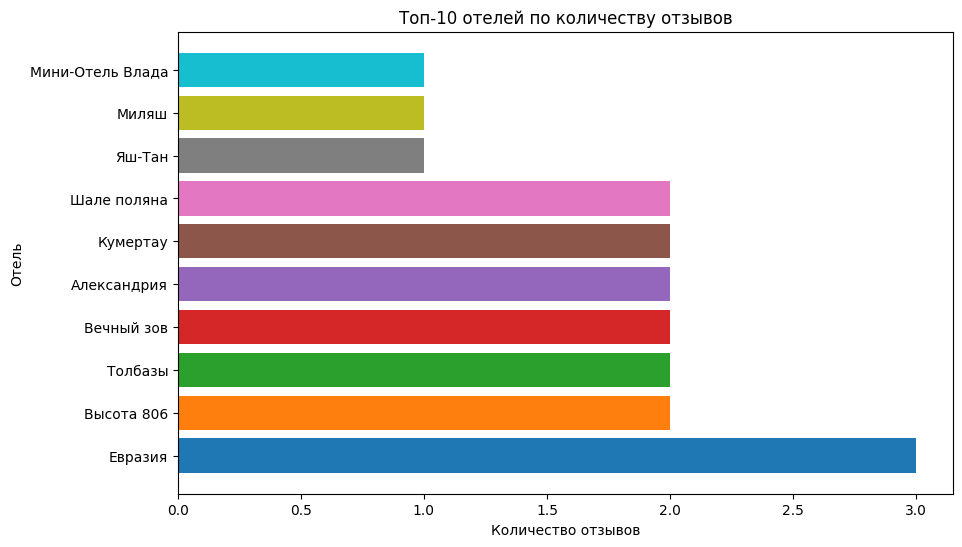

In [98]:
# ищем топ-10 по отзывам среди тех, что имеются в обоих платформах
top_hotels = common_hotels.groupby('title')['review_count'].count().sort_values(ascending = False).head(10)

# строим горизонтальный barplot
plt.figure(figsize=(10, 6))
# цвета для каждого отеля
colors = plt.cm.tab10(np.linspace(0, 1, len(top_hotels)))
# задаем график
plt.barh(top_hotels.index, top_hotels.values, color = colors)
# подписи осей, куда без них
plt.xlabel('Количество отзывов')
plt.ylabel('Отель')
plt.title('Топ-10 отелей по количеству отзывов')

plt.show()


In [99]:
print('Финал')

Финал
